In [1]:
# imports:  
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
torch.manual_seed(0);

In [2]:
x_train = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/x_train.pt').view(-1,1).requires_grad_(True)
x_test = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/x_test.pt').view(-1,1).requires_grad_(True)


# y_test_R_1_5 = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=1.5.pt')
# y_test_R_4 = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=4.pt')
# y_test_R_6 = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=6.pt')

# #Select R
# R = 1.5
# y_test = y_test_R_1_5

test_data = { 1.5:torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=1.5.pt'),
             4:torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=4.pt'),
             6:torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=6.pt')}

# R_values = [1.5, 4, 6]


In [3]:
#Defin the Fully Connected Layers
class FCN(nn.Module):
    def __init__(self, input, output, hidden, V, L):
        super().__init__()
        activation = nn.GELU()
        self.V = V
        self.L = L

        self.net = nn.Sequential(
            nn.Linear(input, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, output),
        )

    def forward(self, t, R):
        #We define how data will flow through our network
        inputs = torch.cat([t,R], dim=1)
        t_output = self.net(inputs)
        t = t * (self.V / self.L + t * t_output)
        #t = t_output * t
        # t = t_output
        return t
        

def calculate_loss_total(pinn, x_train, x_boundary, R, L, C, V):

    # compute boundary loss
    y = pinn(x_boundary, R[:R.size()[0]])# (1, 1)
    loss_IC1 = ((y - 0)**2).mean()
    dydx = torch.autograd.grad(y, x_boundary, torch.ones_like(y), create_graph=True)[0]# (1, 1)
    loss_IC2 = ((dydx - V/L)**2).mean()

    # compute physics loss
    y = pinn(x_train, R)# (30, 1)
    dydx = torch.autograd.grad(y, x_train, torch.ones_like(y), create_graph=True)[0]# (30, 1)
    d2ydx2 = torch.autograd.grad(dydx, x_train, torch.ones_like(dydx), create_graph=True)[0]# (30, 1)
    loss_ODE = torch.mean((d2ydx2 + R/L *dydx + 1/(L*C) * y)**2)

    return loss_ODE + loss_IC1 + loss_IC2

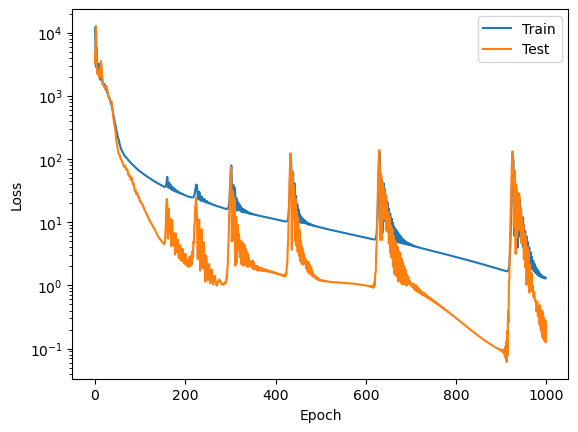

In [4]:
# Assuming x_train contains your time points and you want to generate R values
R_min, R_max = 1, 7
R_values = torch.linspace(R_min, R_max, steps=100).view(-1, 1)  # Generate 100 R values between 1 and 7
R_batch = R_values.repeat(1, x_train.size(0)).view(-1, 1)  # Repeat R values for each time point
t_batch = x_train.repeat(R_values.size(0), 1)  # Repeat time points for each R value

# print(R_batch.size())
# print(t_batch.size())
# print(t_batch)
# print(R_batch)

# Flatten R_batch and t_batch for training
R_batch = R_batch.flatten().view(-1, 1)
t_batch = t_batch.flatten().view(-1, 1)

# Parameters
V = 12
L = 1.2
C = 0.3

#Define a Neurl Network to Train
pinn = FCN(2,1,30, V, L)

# Define an empty list to store loss history
train_loss_history = []
test_loss_history = []

#Define Boundy point, for the boundary loss
# t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
t_boundary = torch.zeros(R_batch.size()[0], 1, requires_grad=True)


# Define Learning Rate
lr = 0.01


 #Train the PINN
optimizer = torch.optim.Adam(pinn.parameters(),lr=lr)

#number of Epochs
epochs = 1000
for epoch in range(epochs):
    R_values = torch.linspace(R_min, R_max, steps=1).view(-1, 1)
    
    optimizer.zero_grad()

    #Calculate Loss
    train_loss = calculate_loss_total(pinn, t_batch, t_boundary, R_batch, L, C, V)

    #Store Loss
    train_loss_history.append(train_loss.detach().item())
    
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # #Test Loss
    R_values = torch.linspace(R_min, R_max, steps=100).view(-1, 1)
    R_batch = R_values.repeat(1, x_train.size(0)).view(-1, 1)
    y_test_pred = pinn(x_test, R_batch)
    test_loss = calculate_loss_total(pinn, x_test, t_boundary, R_batch, L, C, V)
    test_loss_history.append(test_loss.detach().item())

# Plot loss history
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.yscale('log')
plt.legend(['Train','Test']);
plt.xlabel('Epoch');
plt.ylabel('Loss');

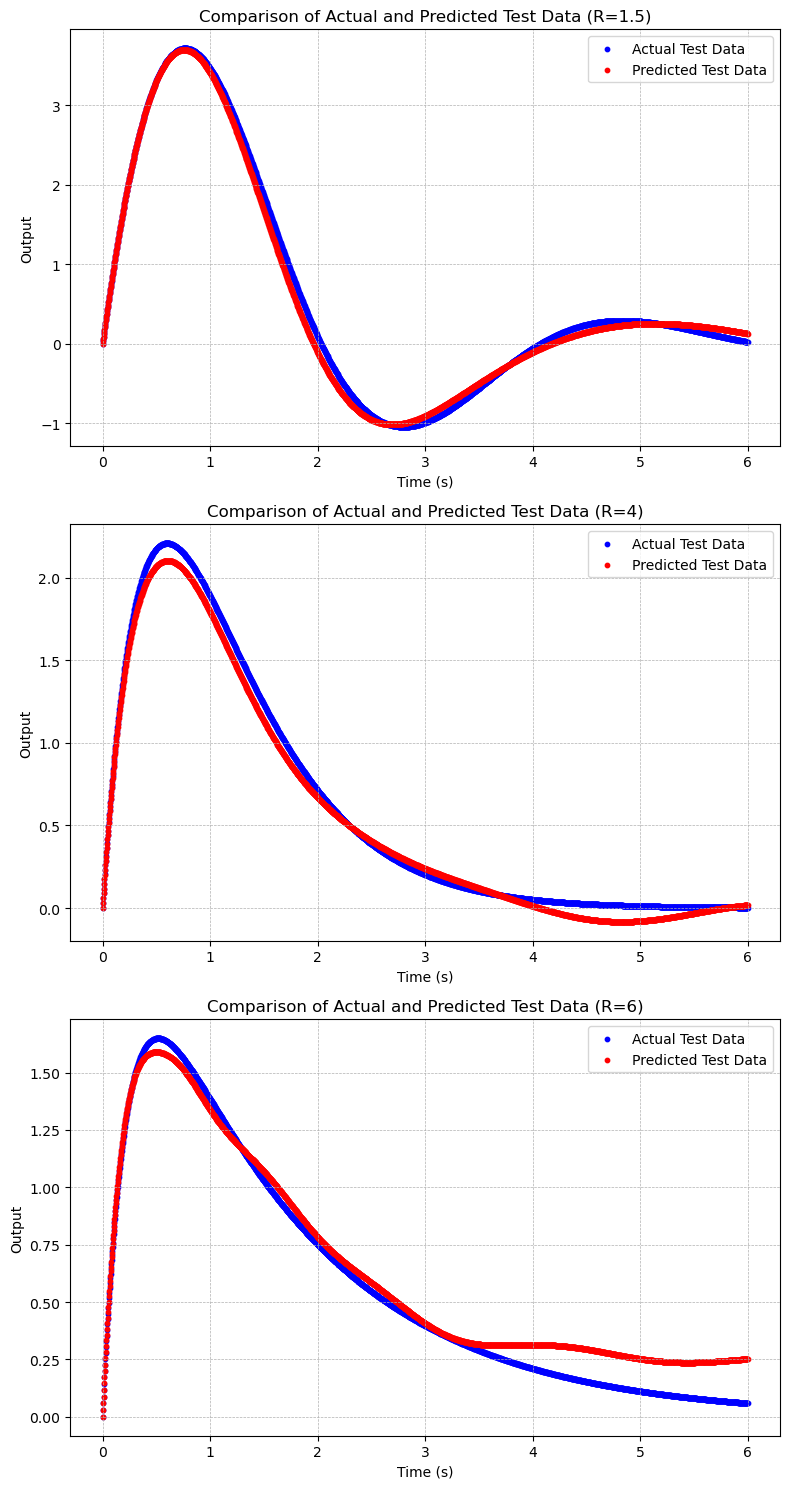

In [5]:
# Define the time range and R value
time_start = 0.0
time_end = 6.0
R_value = 6.0

# Generate a sequence of time points
num_points = 2000  # Number of time points to generate within the range
t_values = torch.linspace(time_start, time_end, num_points).view(-1, 1)  # Reshape to [num_points, 1] for the model

# R values for which to generate predictions and plots
R_test_values = [1.5, 4, 6]

# Create a figure with 3 rows and 1 column
fig, axs = plt.subplots(len(R_test_values), 1, figsize=(8, 15))

for i, R_value in enumerate(R_test_values):
    # Create R tensor for this value, repeated for each t_value
    R_tensor = torch.full_like(t_values, fill_value=R_value)
    
   # Get predictions
    with torch.no_grad():
        predictions = pinn(t_values, R_tensor).numpy()

    # Load corresponding test data
    y_test = test_data[R_value]  # Assuming test data is stored in tensors


    axs[i].scatter(t_values.numpy(), y_test, label='Actual Test Data', color='blue', s=10) 
    axs[i].scatter(t_values.numpy(), predictions, label='Predicted Test Data', color='red', s=10)
    
    
    # Customize plot
    axs[i].set_title(f'Comparison of Actual and Predicted Test Data (R={R_value})')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Output')
    axs[i].legend()
    axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
